## Classification on MNIST Dataset 

In [4]:
# Resources:
# 1. https://www.openml.org/search?type=data&sort=runs&id=554&status=active
# 2. https://scikit-learn.org/
# 3. https://scikit-learn.org/stable/auto_examples/model_selection/plot_nested_cross_validation_iris.html

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
import seaborn as sns
import csv

# Preprocessing
from sklearn.preprocessing import StandardScaler, label_binarize

# Models
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

# Training and Evaluation
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV, KFold, StratifiedKFold, cross_val_score 
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_fscore_support
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, log_loss
from sklearn.metrics import roc_curve, auc
from scipy.stats import uniform, randint
from yellowbrick.classifier import ConfusionMatrix, ROCAUC

# Save results
import logging
from joblib import Parallel, delayed
import pickle

In [7]:
# Fetch MNIST data (might take some time)
mnist = fetch_openml('mnist_784')

X = mnist.data.astype('float32')
y = mnist.target.astype('int64')

# Normalize the data
X /= 255.0

/opt/anaconda3/lib/python3.11/site-packages/sklearn/datasets/_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


## Split the data into Training, Validation, and Test sets

In [9]:
# MNST is already a balanced dataset, with 60k training, 10k test (source 1)
X_train, X_test = X[:60000], X[60000:]
y_train, y_test = y[:60000], y[60000:]

## Standardizing the data

In [11]:
# Fit the standardizing parameters (mean, std. dev) for each column of the training data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)

# Utilize the parameters from the training data to standardize the test set
X_test = scaler.transform(X_test)

## Set Up Pipeline

In [14]:
# Logging results to a savefile
logging.basicConfig(filename='model_evaluation.log', level=logging.INFO, format='%(asctime)s - %(message)s')

# Logistic Regression model initialize
# TUNE HYPERPARAMETERS HERE
model = LogisticRegression(max_iter=10000)
params = {'C': uniform(0.01, 1)}

# This function takes training data and indices for training and validation splits (made by outer cross validation)
def train_and_evaluate(X_train, y_train, train_idx, val_idx):
    # Create training and validation splits from the outer cv indices
    X_train_outer, X_val_outer = X_train[train_idx], X_train[val_idx]
    y_train_outer, y_val_outer = y_train[train_idx], y_train[val_idx]
    
    # Inner cross-validation loop for hyperparameter tuning
    inner_cv = KFold(n_splits=5, shuffle=True, random_state=42)
    random_search = RandomizedSearchCV(estimator=model, param_distributions=params, n_iter=10, cv=inner_cv, n_jobs=-1, random_state=42, verbose=2)

    # Find the best hyperparameters for this fold
    random_search.fit(X_train_outer, y_train_outer)
    best_model = random_search.best_estimator_
    best_params = random_search.best_params_
    
    # Evaluate the model on the validation data for this fold
    y_pred = best_model.predict(X_val_outer)
    val_accuracy = accuracy_score(y_val_outer, y_pred)
    
    return best_model, best_params, val_accuracy

# Outer cross-validation loop with 6 splits
# 5 groups used as training -> 50k train, 10k validation on each fold, mimicking the size of holdout data.
outer_cv = KFold(n_splits=6, shuffle=True, random_state=42)

# Logging information
# Depricated - used when testing multiple models
logging.info("\n=== Training and evaluating Logistic Regression ===")

# Parallelize the outer cross-validation loop for faster processing
results = Parallel(n_jobs=-1)(
    delayed(train_and_evaluate)(X_train, y_train, train_idx, val_idx)
    # Send indexes to split the training data into train/val sets for inner loop
    for train_idx, val_idx in outer_cv.split(X_train)
)

# Initialize arrays for capturing hyper params and evaluation metrics
best_models = []
best_params = []
val_accuracies = []

# Find the best model from each fold
for fold_idx, (best_model, best_param, val_accuracy) in enumerate(results):
    best_models.append(best_model)
    best_params.append(best_param)
    val_accuracies.append(val_accuracy)
    logging.info(f"Fold {fold_idx + 1} - Best Params: {best_param} - Validation Accuracy: {val_accuracy}")

# Logging information
logging.info("=== Training and validation completed for Logistic Regression ===\n")

# Save the best models and parameters
with open('best_models.pkl', 'wb') as f:
    pickle.dump(best_models, f)
with open('best_params.pkl', 'wb') as f:
    pickle.dump(best_params, f)

# Select the model with the highest validation accuracy
best_model_idx = np.argmax(val_accuracies)
best_model = best_models[best_model_idx]
best_params = best_params[best_model_idx]

# Logging information
logging.info(f"\nBest Model: Fold {best_model_idx + 1}")
logging.info(f"Best Params: {best_params}")

# Fit the best model on the entire training dataset
best_model.set_params(**best_params)
best_model.fit(X_train, y_train)

# Evaluate the best model on the test set
y_pred = best_model.predict(X_test)
y_pred_proba = best_model.predict_proba(X_test)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] END ...............................C=0.3845401188473625; total time= 6.5min
[CV] END ...............................C=0.3845401188473625; total time= 6.7min
[CV] END ...............................C=0.3845401188473625; total time= 6.7min
[CV] END ...............................C=0.3845401188473625; total time= 6.9min
[CV] END ...............................C=0.3845401188473625; total time= 7.0min
[CV] END ...............................C=0.3845401188473625; total time= 7.0min
[CV] END ...............................C=0.3845401188473625; total time= 7.0min
[CV] END ...............................C=0.3845401188473625; total

Accuracy: 0.9263
Precision: 0.9261863214314322
Recall: 0.9263
F1 Score: 0.9261577368034174
ROC AUC: 0.9929320381502666
Log Loss: 0.2894351187486839
=== Classification Report ===
              precision    recall  f1-score   support

           0       0.95      0.97      0.96       980
           1       0.96      0.98      0.97      1135
           2       0.93      0.90      0.91      1032
           3       0.91      0.91      0.91      1010
           4       0.94      0.94      0.94       982
           5       0.90      0.87      0.89       892
           6       0.94      0.95      0.95       958
           7       0.93      0.93      0.93      1028
           8       0.88      0.89      0.88       974
           9       0.91      0.92      0.91      1009

    accuracy                           0.93     10000
   macro avg       0.93      0.93      0.93     10000
weighted avg       0.93      0.93      0.93     10000



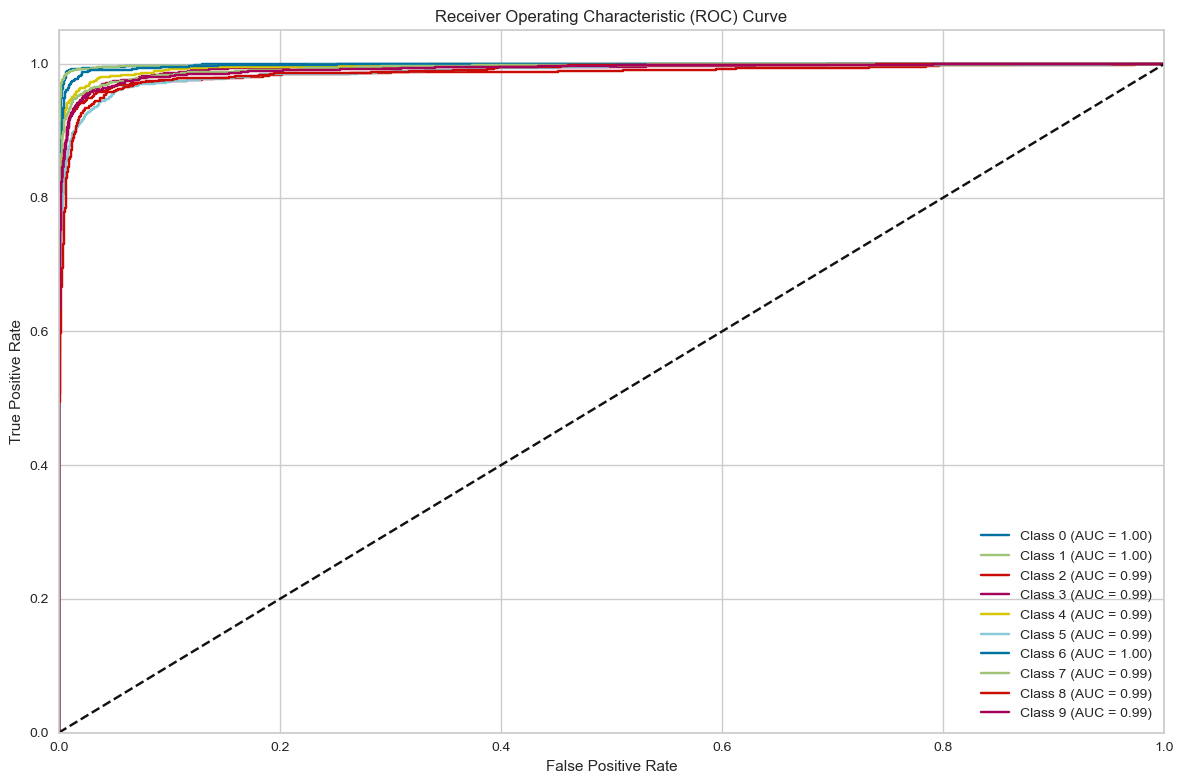

/opt/anaconda3/lib/python3.11/site-packages/yellowbrick/classifier/base.py:232: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  warnings.warn(


<Axes: title={'center': 'LogisticRegression Confusion Matrix'}, xlabel='Predicted Class', ylabel='True Class'>

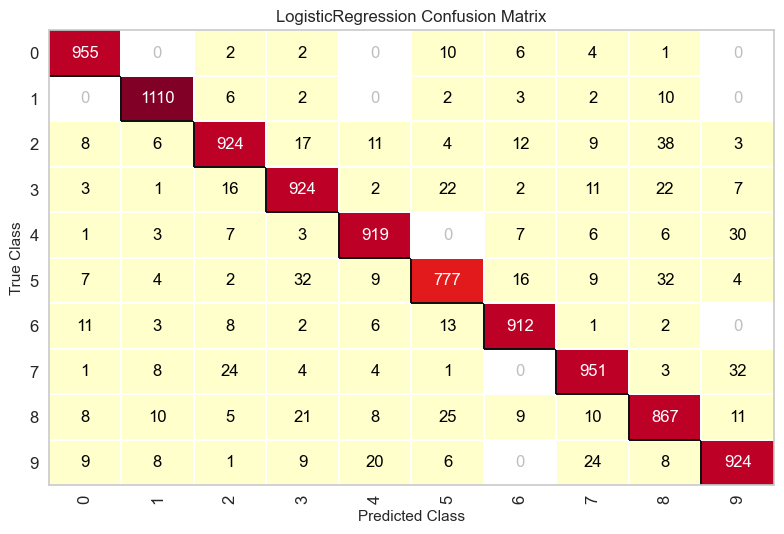

In [19]:
# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
roc_auc = roc_auc_score(y_test, y_pred_proba, multi_class='ovr')
logloss = log_loss(y_test, y_pred_proba)
conf_matrix = confusion_matrix(y_test, y_pred)

# Save metrics
metrics = {
    'accuracy': accuracy,
    'precision': precision,
    'recall': recall,
    'f1': f1,
    'roc_auc': roc_auc,
    'logloss': logloss,
    'conf_matrix': conf_matrix
}

with open('metrics.pkl', 'wb') as f:
    pickle.dump(metrics, f)

# Print metrics
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("ROC AUC:", roc_auc)
print("Log Loss:", logloss)

# Print classification report
class_report_test = classification_report(y_test, y_pred)
print(f"=== Classification Report ===\n{class_report_test}")

# Save classification report
with open('classification_report.txt', 'w') as f:
    f.write(class_report_test)

# One-vs-All ROC Curve
n_classes = y_pred_proba.shape[1]
y_test_bin = label_binarize(y_test, classes=np.arange(n_classes))

plt.figure(figsize=(12, 8))
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_pred_proba[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Class {i} (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.tight_layout()
plt.savefig('roc_curve.png')
plt.show()
plt.close()

# Yellowbrick Confusion Matrix
cm = ConfusionMatrix(best_model, classes=np.unique(y_test))
cm.score(X_test, y_test)
cm.poof(outpath="confusion_matrix_yellowbrick.png")